# Basic Spectrum Generation

The first and most simple way in which TARDIS calculates spectra calculates it directly from the Monte Carlo packets after the final [Monte Carlo Iteration](../montecarlo/index.rst). This simply requires knowledge of the each packet's energy and frequency in the lab frame (see [Reference Frames](../montecarlo/propagation.rst#reference-frames)) at the end of the iteration. The only other quantity needed is the time duration of the simulation $\Delta t$, which is calculated based off of the luminosity of the supernova's photosphere (see [Energy Packet Initialization](../montecarlo/initialization.ipynb)).

<div class="alert alert-info">

Note

The only packets which are used for this calculation are the packets which escape the outer boundary of the
computational domain -- those reabsorbed into the photosphere are not included (see [Packet Propagation](../montecarlo/propagation.rst)).

</div>

The spectrum calculation is very straightforward. A packet of energy $E_\mathrm{packet}$ contributes a
luminosity

$$L_\mathrm{packet} = \frac{E_\mathrm{packet}}{\Delta t}$$

to the spectrum at its frequency.

In [1]:
from tardis.io.config_reader import Configuration
from tardis.simulation import Simulation
from tardis.montecarlo import TARDISSpectrum
from tardis.util.base import quantity_linspace
from astropy import units as u
import numpy as np

/home/smithis7/anaconda3/envs/tardis/lib/python3.7/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/home/smithis7/anaconda3/envs/tardis/lib/python3.7/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
tardis_config = Configuration.from_yaml('tardis_example.yml')

sim = Simulation.from_config(tardis_config)

sim.iterate(10000)

/home/smithis7/anaconda3/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),


In [3]:
nus = sim.runner.output_nu
nus

<Quantity [5.15024364e+14, 1.03147263e+15, 1.18867809e+15, ...,
           3.80118923e+14, 7.18776379e+14, 7.48218831e+14] Hz>

In [4]:
energies = sim.runner.output_energy
energies

<Quantity [ 9.91993166e-05, -9.64702729e-05,  1.03051369e-04, ...,
            1.01593634e-04,  1.03703185e-04,  9.71755356e-05] erg>

In [21]:
len(nus), len(energies)

(10000, 10000)

In [16]:
luminosities = energies / sim.runner.time_of_simulation
luminosities

<Quantity [ 1.05079491e+39, -1.02188679e+39,  1.09159879e+39, ...,
            1.07615735e+39,  1.09850333e+39,  1.02935748e+39] erg / s>

In [6]:
emitted_mask = sim.runner.emitted_packet_mask
emitted_mask

array([ True, False,  True, ...,  True,  True,  True])

In [17]:
emitted_nus = nus[emitted_mask]
emitted_nus

7431

In [18]:
emitted_luminosities = luminosities[emitted_mask]
emitted_luminosities

7431

In [23]:
len(emitted_nus), len(emitted_luminosities)

(7431, 7431)

In [9]:
freq_start = 1.5e14 * u.Hz
freq_stop = 3e15 * u.Hz
N = 500

In [24]:
spectrum_frequency = quantity_linspace(freq_start, freq_stop, N + 1,)
spectrum_frequency

<Quantity [1.5000e+14, 1.5570e+14, 1.6140e+14, 1.6710e+14, 1.7280e+14,
           1.7850e+14, 1.8420e+14, 1.8990e+14, 1.9560e+14, 2.0130e+14,
           2.0700e+14, 2.1270e+14, 2.1840e+14, 2.2410e+14, 2.2980e+14,
           2.3550e+14, 2.4120e+14, 2.4690e+14, 2.5260e+14, 2.5830e+14,
           2.6400e+14, 2.6970e+14, 2.7540e+14, 2.8110e+14, 2.8680e+14,
           2.9250e+14, 2.9820e+14, 3.0390e+14, 3.0960e+14, 3.1530e+14,
           3.2100e+14, 3.2670e+14, 3.3240e+14, 3.3810e+14, 3.4380e+14,
           3.4950e+14, 3.5520e+14, 3.6090e+14, 3.6660e+14, 3.7230e+14,
           3.7800e+14, 3.8370e+14, 3.8940e+14, 3.9510e+14, 4.0080e+14,
           4.0650e+14, 4.1220e+14, 4.1790e+14, 4.2360e+14, 4.2930e+14,
           4.3500e+14, 4.4070e+14, 4.4640e+14, 4.5210e+14, 4.5780e+14,
           4.6350e+14, 4.6920e+14, 4.7490e+14, 4.8060e+14, 4.8630e+14,
           4.9200e+14, 4.9770e+14, 5.0340e+14, 5.0910e+14, 5.1480e+14,
           5.2050e+14, 5.2620e+14, 5.3190e+14, 5.3760e+14, 5.4330e+14,
      

In [11]:
emitted_luminosity_hist = u.Quantity(np.histogram(emitted_nus,
                                                  weights=emitted_luminosities,
                                                  bins=spectrum_frequency.value,
                                                 )[0], "erg / s",)
emitted_luminosity_hist

<Quantity [1.28762188e+40, 1.51537652e+40, 1.83472455e+40, 1.18413698e+40,
           1.62502763e+40, 2.45896256e+40, 1.60567236e+40, 2.23435434e+40,
           1.19099721e+40, 1.29189981e+40, 2.26960450e+40, 2.80357255e+40,
           2.25551060e+40, 3.21021738e+40, 2.47344815e+40, 2.79827095e+40,
           2.68735217e+40, 2.37451224e+40, 2.48726399e+40, 2.24735794e+40,
           3.88466239e+40, 3.78224110e+40, 3.11909104e+40, 2.36154901e+40,
           2.92580735e+40, 3.74808465e+40, 4.07002080e+40, 3.12904167e+40,
           3.77553585e+40, 3.88293704e+40, 3.13109192e+40, 2.67828850e+40,
           3.32604293e+40, 3.64567521e+40, 4.63706239e+40, 3.56372007e+40,
           4.10064957e+40, 3.66237973e+40, 3.75928478e+40, 4.19457400e+40,
           3.97335971e+40, 4.65475755e+40, 3.21914462e+40, 5.69773928e+40,
           3.98783133e+40, 4.53841948e+40, 4.32302809e+40, 5.25396693e+40,
           4.83802822e+40, 4.73762308e+40, 4.84330614e+40, 5.04960503e+40,
           4.00559426e+40

In [12]:
spectrum = TARDISSpectrum(spectrum_frequency, emitted_luminosity_hist)

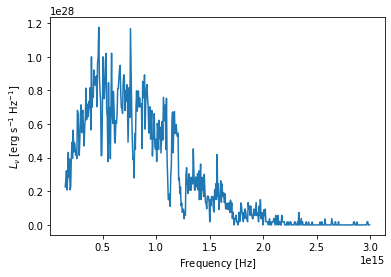

In [13]:
spectrum.plot(mode='frequency')

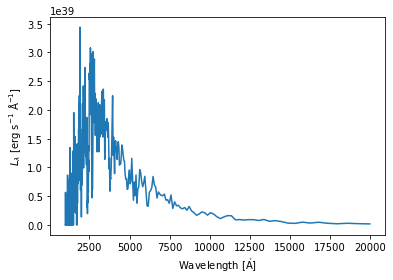

In [14]:
spectrum.plot(mode='wavelength')